# M1. URBAN MOVEMENT MODEL

En este reporte se mostrará una simulación del tráfico que se genera en una intersección de cuatro diferentes calles, con dos carriles cada una de ellas.

## Descripción del Reto

El tráfico es un problema que va en aumento debido al incremento en población de las ciudades, esto a su vez aparte de hacer perder tiempo a las personas en el congestionamiento que se genera por los semáforos, hace perder dinero y genera mayor contaminación al tener que utilizar más gasolina en un número de automóviles incrementado. Para dar solución a este problema se ha intentado ampliar la infraestructura con la finalidad de dar más opciones de rutas a los usuarios y de esta manera aliviar el tráfico. También se ha restringido en ciertas ciudades la circulación por días dependiendo del último dígito de la placa de los automóviles a pesar de que no en todos sus casos de aplicación resultó ser una medida eficiente ya que los usuarios en lugar de utilizar transporte público, adquirió un mayor número de automóviles con la finalidad de poder circular todos los días posibles. 


## ¿Cómo funciona el modelo?

Para la solución del reto se asume que cada calle será doble carril y de doble sentido, los únicos colores de semáforos que se utilizarán serán el verde y rojo. Todos los vehículos utilizarán las mismas magnitudes de aceleración, desaceleración para el frenado e iran a la máxima velocidad permitida de 60 km/h. Para visualizar la solución de congestión de tráfico se representará de forma gráfica el cruce de 2 calles, es decir de una intersección, en la que cada carro podrá tomar cualquier dirección aleatoriamente. Al representar una intersección existirán 4 semáforos, uno por cada entrada de carros a la misma y se asume que tan solo 1 de ellos podrá estar encendido a la vez.


In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Importamos la fila de doble fin para guardar a los agentes 
from collections import deque 

from random import random

In [2]:
# # Clase de Road que tendra vehiculos y traffic light...
# class Road:
#     def __init__(self, start, end):
#         self.start = start
#         self.end = end
#         self.length = distance.euclidean(self.start, self.end)
    
#     def update(self, dt):
#         n = len(self.vehicles)

#         if n > 0:
#         # Update first vehicle
#         self.vehicles[0].update(None, dt)
#         # Update other vehicles
#         for i in range(1, n):
#             lead = self.vehicles[i-1]
#             self.vehicles[i].update(lead, dt)

        

In [3]:
# class Simulation: 
#     def __init__(self, config={}):
#         # Set default configuration
#         self.set_default_config()

#         # Update configuration
#         for attr, val in config.items():
#             setattr(self, attr, val)

#     def set_default_config(self):
#         self.t = 0.0            # Time keeping
#         self.frame_count = 0    # Frame count keeping
#         self.dt = 1/60          # Simulation time step
#         self.roads = []         # Array to store roads

#     def create_road(self, start, end):
#         road = Road(start, end)
#         self.roads.append(road)
#         return road

#     def create_roads(self, road_list):
#         for road in road_list:
#             self.create_road(*road)
            
#     def update(self):
#         # Update every road
#         for road in self.roads:
#             road.update(self.dt)

#         # Check roads for out of bounds vehicle
#         for road in self.roads:
#             # If road has no vehicles, continue
#             if len(road.vehicles) == 0: continue
#             # If not
#             vehicle = road.vehicles[0]
#             # If first vehicle is out of road bounds
#             if vehicle.x >= road.length:
#                 # If vehicle has a next road
#                 if vehicle.current_road_index + 1 < len(vehicle.path):
#                     # Update current road to next road
#                     vehicle.current_road_index += 1
#                     # Create a copy and reset some vehicle properties
#                     new_vehicle = deepcopy(vehicle)
#                     new_vehicle.x = 0
#                     # Add it to the next road
#                     next_road_index = vehicle.path[vehicle.current_road_index]
#                     self.roads[next_road_index].vehicles.append(new_vehicle)
#                 # In all cases, remove it from its road
#                 road.vehicles.popleft() 

In [4]:
class CarAgent(Agent):
    def __init__(self, unique_id, model, width, height, origin, destiny, traffic_light, stop_distance, road_queue_position, road_number, curve_origin, curve_destiny, num_traffic_light):
        super().__init__(unique_id, model)
        
        # Vector que representa la posición en 2D
        self.position = np.array((origin[0], origin[1]), dtype = np.float64)
        self.origin_road = origin
        self.destiny_road = destiny
        self.traffic_light = traffic_light
        self.stop_distance = stop_distance
        self.next_car_max_distance = 50
        self.road_queue_position = road_queue_position
        self.road_number = road_number
        self.curve_origin = curve_origin
        self.curve_destiny = curve_destiny
        self.num_traffic_light = num_traffic_light
    
        # Vector que representa la velocidad
        if origin[0] > width / 2 - stop_distance * 2 and origin[0] < width / 2 + stop_distance * 2:
            if origin[1] < height / 2:
                self.velocity = np.array([0, 10])
                self.acceleration = np.array([0, 10])
            else:
                self.velocity = np.array([0, -10])
                self.acceleration = np.array([0, -10])
        else:
            if origin[0] < width / 2:
                self.velocity = np.array([10, 0])
                self.acceleration = np.array([10, 0])
            else:
                self.velocity = np.array([-10, 0])
                self.acceleration = np.array([-10, 0])
        
        
        # Límite de aceleración
        self.max_acceleration = 10
        
        # Límite de velocidad
        self.max_speed = 60
        
        # Distancia percibida como segura por el agente
        self.perception = 50
        
        self.width = width
        self.height = height
        self.crossed_traffic_light = False
        self.curved_finished = False

    def move(self):        
        # Incluir condicion de semaforo prendido
        isFront = (self.model.roads_agents[self.road_number][0].unique_id == self.unique_id)
        
        if (isFront and self.isFarFromTrafficLight()) or self.isFarFromNextCar(isFront):
            self.position += self.velocity
            self.velocity += self.acceleration
            
            if np.linalg.norm(self.velocity) > self.max_speed:
                self.velocity = self.velocity / np.linalg.norm(self.velocity) * self.max_speed
        else:
            if np.linalg.norm(self.velocity) > 0:
                self.velocity -= self.acceleration
                self.position += self.velocity
            else:
                self.velocity *= 0
    
        if (abs(np.linalg.norm(self.position - self.curve_origin)) <= 50):
            self.crossed_traffic_light = True
            self.model.roads_agents[self.road_number].popleft()
            # Si no es una línea recta
            if (self.position[0] - self.curve_destiny[0]) * (self.position[1] - self.curve_destiny[1]) != 0:
                self.curve_points = self.curve(self.position, self.curve_destiny)
                self.temp = 0
            else:
                self.curved_finished = True

    
    def step(self):
        if not self.crossed_traffic_light:
            self.move()
        elif self.curved_finished == True:
                self.velocity = self.destiny_road - self.position
                if np.linalg.norm(self.velocity) > self.max_speed:
                    self.velocity = self.velocity / np.linalg.norm(self.velocity) * self.max_speed
                
                self.position += self.velocity
        else:
            if self.temp < len(self.curve_points):
                vec = (self.curve_points[self.temp][0] - self.position)
                self.velocity = vec
                self.position += self.velocity
                self.temp += 1
            else:
                self.curved_finished = True

    def get_car_index(self):
        bot = 0
        top = len(self.model.roads_agents[self.road_number]) - 1
        target_id = self.unique_id
        
        while bot <= top:
            mid = int (bot + (top - bot) / 2)
            current_id = self.model.roads_agents[self.road_number][mid].unique_id
            
            if current_id == target_id:
                return mid
            elif current_id > target_id:
                top = mid - 1
            else:
                bot = mid + 1
            
        return -1
    
    
    def isFarFromTrafficLight(self):
        return (abs(np.linalg.norm(self.position + self.velocity - self.traffic_light)) > self.stop_distance * 1.5)
    
    def isFarFromNextCar(self, isFront):
        if isFront:
            return False
        else: 
            queue_position = self.get_car_index()
            next_car = self.model.roads_agents[self.road_number][queue_position - 1]
            self_speed = np.linalg.norm(self.velocity)
            self_acceleration = np.linalg.norm(self.acceleration)
            distance_to_stop = abs(0.5 * self_speed * self_speed / self_acceleration) + 80
            return (abs(np.linalg.norm((self.position + self.velocity) - (next_car.position + next_car.velocity))) > distance_to_stop)


    def curve_points(self, start, end, control, resolution=5):
            
        path = []
        for i in range(resolution+1):
            t = i/resolution
            x = (1-t)**2 * start[0] + 2*(1-t)*t * control[0] + t**2 *end[0]
            y = (1-t)**2 * start[1] + 2*(1-t)*t * control[1] + t**2 *end[1]
            path.append((x, y))

        return [(path[i-1], path[i]) for i in range(1, len(path))]

    def curve(self, start, end):
        turn_direction = 0
        resolution = 15
        if (self.num_traffic_light == 0):
            if (end[0] > start[0] and end[1] > start[1]):
                turn_direction = 0
                resolution = 5
            elif(end[0] < start[0] and end[1] > start[1]):
                turn_direction = 1
        elif (self.num_traffic_light == 1):
            if (end[0] < start[0] and end[1] > start[1]):
                turn_direction = 0
                resolution = 5
            elif(end[0] < start[0] and end[1] < start[1]):
                turn_direction = 1
        elif (self.num_traffic_light == 2):
            if (end[0] < start[0] and end[1] < start[1]):
                turn_direction = 0
                resolution = 5
            elif(end[0] > start[0] and end[1] < start[1]):
                turn_direction = 1
        elif (self.num_traffic_light == 3):
            if (end[0] > start[0] and end[1] < start[1]):
                turn_direction = 0
                resolution = 5
            elif(end[0] > start[0] and end[1] > start[1]):
                turn_direction = 1


        CLOCK_WISE = 0
        NON_CLOCK_WISE = 1
        # Get control point
        x = min(start[0], end[0])
        y = min(start[1], end[1])

        if turn_direction == CLOCK_WISE:
            control = (x - y + start[1], y - x + end[0])
        else:
            control = (x - y + end[1], y - x + start[0])
        
        return self.curve_points(start, end, control, resolution=resolution)


In [5]:
def get_agents(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

class UrbanMovementModel(Model):
    def __init__(self, spawn_cars, w, h, i_dist):
        self.num_agents = 0
        self.spawn_cars = spawn_cars
        self.width = w
        self.height = h
        self.schedule = RandomActivation(self)
        self.i_dist = i_dist
        
        # (carril, semáforo, [carriles destino])
        self.intersection = [(1, 1, [8, 12]), (2, 1, [3, 7]), 
                             (5, 2, [12, 16]), (6, 2, [7, 11]),
                             (9, 3, [4, 16]), (10, 3, [11, 15]), 
                             (13, 4, [4, 8]), (14, 4, [3, 15])]
        
        self.road_pos = [[w / 2 + i_dist / 8, 0], [w / 2 + i_dist / 8 * 3, 0],
                        [w, h / 2 - i_dist / 8 * 3], [w, h / 2 - i_dist / 8],
                        [w, h / 2 + i_dist / 8], [w, h / 2 + i_dist / 8 * 3],
                        [w / 2 + i_dist / 8 * 3, h], [w / 2 + i_dist / 8, h],
                        [w / 2 - i_dist / 8, h], [w / 2 - i_dist / 8 * 3, h],
                        [0, h / 2 + i_dist / 8 * 3], [0, h / 2 + i_dist / 8],
                        [0, h / 2 - i_dist / 8], [0, h / 2 - i_dist / 8 * 3],
                        [w / 2 - i_dist / 8 * 3, 0], [w / 2 - i_dist / 8, 0]]

        self.curve = [  [w / 2 + i_dist / 8, h / 2 - i_dist / 2], [w / 2 + i_dist / 8 * 3, h / 2 - i_dist / 2],
                        [w / 2 + i_dist / 2, h / 2 - i_dist / 8 * 3], [w / 2 + i_dist / 2, h / 2 - i_dist / 8], 
                        [w / 2 + i_dist / 2, h / 2 + i_dist / 8], [w / 2 + i_dist / 2, h / 2 + i_dist / 8 * 3],
                        [w / 2 + i_dist / 8 * 3, h / 2 + i_dist / 2], [w / 2 + i_dist / 8, h / 2 + i_dist / 2], 
                        [w / 2 - i_dist / 8, h / 2 + i_dist / 2], [w / 2 - i_dist / 8 * 3, h / 2 + i_dist / 2],
                        [w / 2 - i_dist / 2, h / 2 + i_dist / 8 * 3], [w / 2 - i_dist / 2, h / 2 + i_dist / 8], 
                        [w / 2 - i_dist / 2, h / 2 - i_dist / 8], [w / 2 - i_dist / 2, h / 2 - i_dist / 8 * 3],
                        [w / 2 - i_dist / 8 * 3, h / 2 - i_dist / 2], [w / 2 - i_dist / 8, h / 2 - i_dist / 2]]

        self.light_pos = [[w / 2 + i_dist / 4, h / 2 - i_dist / 2],
                        [w / 2 + i_dist / 2, h / 2 + i_dist / 4],
                        [w / 2 - i_dist / 4, h / 2 + i_dist / 2],
                        [w / 2 - i_dist / 2, h / 2 - i_dist / 4]]
        
        self.roads_agents = [deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), 
                            deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), deque([]), deque([])]
        
        self.time_for_spawn = np.array([0, 0, 0, 0, 0, 0, 0, 0])
        
        self.createAgents()

        self.datacollector = DataCollector(model_reporters = {"Agents" : get_agents})

    def createAgents(self):
        for i in range(len(self.intersection)):
            if self.time_for_spawn[i] <= 0 and random() <= self.spawn_cars:
                self.time_for_spawn[i] = 3
                self.num_agents += 1
                (road, light, dest) = self.intersection[i]
                j = np.random.randint(len(dest))
                a = CarAgent(self.num_agents, 
                             self, 
                             self.width, 
                             self.height, 
                             self.road_pos[road - 1], 
                             self.road_pos[dest[j] - 1], 
                             self.light_pos[light - 1], 
                             self.i_dist / 4, 
                             len(self.roads_agents[road - 1]), 
                             road - 1,
                             self.curve[road - 1],
                             self.curve[dest[j] - 1],
                             light - 1)
                self.roads_agents[road - 1].append(a)
                self.schedule.add(a)

    def step(self):
        self.createAgents()
        self.time_for_spawn -= 1
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
WIDTH = 2500
HEIGHT = 1250
INTERSECT_DIST = 400
PROB_SPAWN = 0.15
MAX_ITERATIONS = 100

model = UrbanMovementModel(PROB_SPAWN, WIDTH, HEIGHT, INTERSECT_DIST)
for i in range(MAX_ITERATIONS):
    model.step()
    

In [7]:
all_positions = model.datacollector.get_model_vars_dataframe()

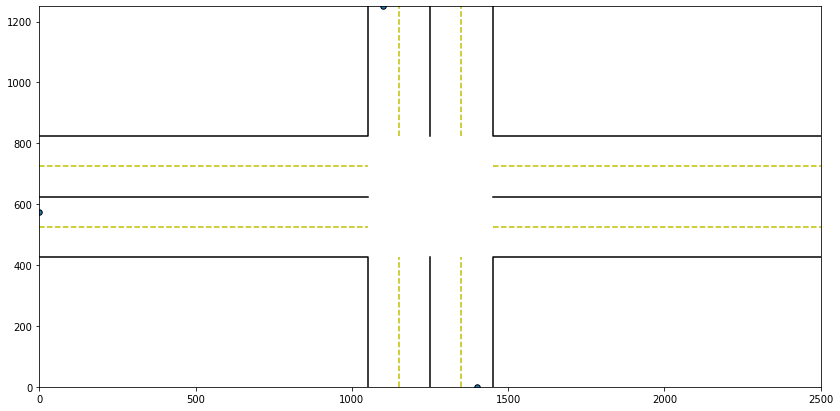

In [8]:
fig, ax = plt.subplots(figsize=(14,7))

# El segundo 0 es el diccionario que estoy manejando; después se utiliza el slice para tomar las x de los vectores de 2.
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], 
                s=30, cmap="jet", edgecolor = "k")

# Corners
x1 = [0, WIDTH / 2 - INTERSECT_DIST / 2, WIDTH / 2 - INTERSECT_DIST / 2]
y1 = [HEIGHT / 2 - INTERSECT_DIST / 2, HEIGHT / 2 - INTERSECT_DIST / 2, 0]
plt.plot(x1, y1, color='black')
y2 = [HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT]
plt.plot(x1, y2, color='black')
x2 = [WIDTH, WIDTH / 2 + INTERSECT_DIST / 2, WIDTH / 2 + INTERSECT_DIST / 2]
plt.plot(x2, y2, color='black')
plt.plot(x2, y1, color='black')

# Izquierda
xlane = [0, WIDTH / 2 - INTERSECT_DIST / 2]
ylane = [HEIGHT / 2, HEIGHT / 2]
plt.plot(xlane, ylane, color='black')
ylane = [HEIGHT / 2 - INTERSECT_DIST / 4, HEIGHT / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
ylane = [HEIGHT / 2 + INTERSECT_DIST / 4, HEIGHT / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Derecha
xlane = [WIDTH / 2 + INTERSECT_DIST / 2, WIDTH]
ylane = [HEIGHT / 2, HEIGHT / 2]
plt.plot(xlane, ylane, color='black')
ylane = [HEIGHT / 2 - INTERSECT_DIST / 4, HEIGHT / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
ylane = [HEIGHT / 2 + INTERSECT_DIST / 4, HEIGHT / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Abajo
xlane = [WIDTH / 2, WIDTH / 2]
ylane = [0, HEIGHT / 2 - INTERSECT_DIST / 2]
plt.plot(xlane, ylane, color='black')
xlane = [WIDTH / 2 - INTERSECT_DIST / 4, WIDTH / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
xlane = [WIDTH / 2 + INTERSECT_DIST / 4, WIDTH / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
# Arriba
xlane = [WIDTH / 2, WIDTH / 2]
ylane = [HEIGHT / 2 + INTERSECT_DIST / 2, HEIGHT]
plt.plot(xlane, ylane, color='black')
xlane = [WIDTH / 2 - INTERSECT_DIST / 4, WIDTH / 2 - INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')
xlane = [WIDTH / 2 + INTERSECT_DIST / 4, WIDTH / 2 + INTERSECT_DIST / 4]
plt.plot(xlane, ylane, color='y', linestyle='--')

for i in range(len(model.curve)):
    plt.plot()

ax.axis([0, WIDTH, 0, HEIGHT])
def update(frame_number):
    # Arreglo de pares x, y.
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    return scatter

anim = animation.FuncAnimation(fig, update, frames = MAX_ITERATIONS)

In [9]:
anim